In [16]:
from typing import Optional

import numpy as np

import torch
import torch.distributions as D

import nll_to_po.models.dn_policy as Policy
from nll_to_po.training.utils import (
    train_single_policy,
    set_seed_everywhere,
)
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

### Data utils

In [2]:
def generate_data_single_point(
    input_dim: int,
    output_dim: int,
    init_dist_loc: Optional[float] = None,
    init_dist_scale: Optional[float] = None,
    init_dist_n_samples: int = 1,
):
    set_seed_everywhere(seed=np.random.randint(0, 1e6))

    # resample parameters
    if not init_dist_loc:
        init_dist_loc = np.random.uniform(-5.0, 5.0)
    if not init_dist_scale:
        init_dist_scale = np.random.uniform(1.0, 2.5)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    mean_y_expanded = mean_y.repeat_interleave(init_dist_n_samples, dim=0)
    y = mean_y_expanded + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]
    std_y = torch.full_like(mean_y_expanded, init_dist_scale)

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y, mean_y_expanded, std_y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    return (
        train_dataloader,
        None,
        None,
        {
            "init_dist_loc": init_dist_loc,
            "init_dist_scale": init_dist_scale,
            "init_dist_n_samples": init_dist_n_samples,
        },
    )

### Generate data and policy

In [143]:
# Experiment parameters
n_updates: int = 50
learning_rate: float = 0.01

# Policy architecture
input_dim: int = 2
output_dim: int = 2
hidden_sizes: list[int] = [64, 64]
fixed_logstd: bool = False

# policy = Policy.LinearGaussian(input_dim, output_dim, fixed_logstd)
policy = Policy.MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

# Data generating dist q

init_dist_loc: float = 5.0
init_dist_scale: float = 0.75
init_dist_n_samples: int = 10

train_dataloader, val_dataloader, test_dataloader, data_config = (
    generate_data_single_point(
        input_dim=input_dim,
        output_dim=output_dim,
        init_dist_loc=init_dist_loc,
        init_dist_scale=init_dist_scale,
        init_dist_n_samples=init_dist_n_samples,
    )
)

### Baselines: NLL

In [169]:
_, _, _, _, dist_nll = train_single_policy(
    policy=policy,
    train_dataloader=train_dataloader,
    loss_function=L.NLL(),
    n_updates=n_updates + 1,
    learning_rate=learning_rate,
    early_stopping_patience=n_updates,
    return_dist=True,
)

Training epochs: 100%|██████████| 51/51 [00:00<00:00, 450.64it/s]


### PG Entropy Reg

In [199]:
n_generations: int = 5
use_rsample: bool = False
reward_transform: str = "normalize"
entropy_weight_list = [round(lamda, 2) for lamda in np.logspace(-2, 1, num=5)]
entropy_weight_list = [0.1]

all_dist_pg_list = []
for entropy_weight in entropy_weight_list:
    dist_pg = {}
    for u_star, label in [
        (
            (entropy_weight) / (2 * (init_dist_scale**2)),
            r"PG($U^\star=\frac{\lambda n}{2 Tr(\Sigma)}I$)",
        ),
        (1.0, r"PG($U=I$)"),
    ]:
        # Define reward function
        reward_fn = R.Mahalanobis(matrix=u_star * torch.eye(output_dim))

        # Define the loss function
        loss_function = L.PG(
            reward_fn=reward_fn,
            n_generations=n_generations,
            use_rsample=use_rsample,
            reward_transform=reward_transform,
            entropy_weight=entropy_weight,
        )

        _, _, _, _, dist = train_single_policy(
            policy=policy,
            train_dataloader=train_dataloader,
            loss_function=loss_function,
            n_updates=n_updates + 1,
            learning_rate=learning_rate,
            early_stopping_patience=n_updates,
            return_dist=True,
        )

        dist_pg[label] = dist
    all_dist_pg_list.append(dist_pg)

Training epochs: 100%|██████████| 51/51 [00:00<00:00, 380.83it/s]


### plot

In [200]:
import seaborn as sns

# initial distribution
for X, _, mu, sigma in train_dataloader:
    mean, std = policy(X)
    initial_dist = D.Normal(mean[0], std[0])
    # gt
    gt_dist = D.Normal(mu[0], sigma[0])
    break  # Only need first batch


def plot_distribution_comparison(
    dist_nll,
    dist_pg,
    indices,
    n_samples=100,
    xlim=None,
    ylim=None,
    save_path=None,
    scatter_size=35,
    alpha=0.4,
):
    """
    Plot scatter plots comparing distributions at specified indices.

    Args:
        dist_nll: List of torch normal distributions from NLL training
        dist_pg: Dict of lists of torch normal distributions from PG training
        indices: List of indices to plot
        n_samples: Number of samples to draw from each distribution
    """
    n_plots = len(indices)
    fig, axes = plt.subplots(1, n_plots, figsize=(2 * n_plots, 2))

    # Handle single subplot case
    if n_plots == 1:
        axes = [axes]

    # Define colors for each method
    # Get first two colors from default seaborn palette
    default_palette = sns.color_palette()

    colors = {
        "Initial": "gray",
        "Ground Truth": "black",
        "NLL": "red",
        list(dist_pg.keys())[0]: default_palette[1],
        list(dist_pg.keys())[1]: default_palette[0],
    }

    # Keep track of labels for single legend
    handles, labels = [], []

    for i, idx in enumerate(indices):
        ax = axes[i]

        # Plot initial distribution
        samples_initial = initial_dist.sample((n_samples,))
        scatter = ax.scatter(
            samples_initial[:, 0],
            samples_initial[:, 1],
            alpha=alpha,
            s=scatter_size,
            color=colors["Initial"],
            label="Initial",
            marker="x",
        )
        if i == 0:
            handles.append(scatter)
            labels.append("Initial")

        # Plot ground truth distribution
        samples_gt = gt_dist.sample((n_samples,))
        scatter = ax.scatter(
            samples_gt[:, 0],
            samples_gt[:, 1],
            alpha=0.3,
            s=scatter_size,
            color=colors["Ground Truth"],
            label="Ground Truth",
            marker="^",
        )
        if i == 0:
            handles.append(scatter)
            labels.append("Target")

        # Plot NLL distribution if available
        if idx < len(dist_nll) and dist_nll[idx] is not None:
            samples_nll = dist_nll[idx].sample((n_samples,))
            # Plot first two dimensions
            scatter = ax.scatter(
                samples_nll[:, 0],
                samples_nll[:, 1],
                alpha=alpha,
                s=scatter_size,
                color=colors["NLL"],
                label="NLL",
                # edgecolors="black",
            )
            if i == 0:  # Only collect handles from first subplot
                handles.append(scatter)
                labels.append("NLL")

        # Plot PG distributions
        for method_name, dist_list in dist_pg.items():
            if idx < len(dist_list) and dist_list[idx] is not None:
                samples_pg = dist_list[idx].sample((n_samples,))
                scatter = ax.scatter(
                    samples_pg[:, 0],
                    samples_pg[:, 1],
                    alpha=alpha,
                    s=scatter_size,
                    color=colors[method_name],
                    label=method_name,
                )  # edgecolors='black')
                if i == 0:  # Only collect handles from first subplot
                    handles.append(scatter)
                    labels.append(method_name)

        ax.set_title(f"epoch {idx}")
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.grid(True, alpha=0.3)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

    # Add single legend centered below all subplots
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.24),
        ncol=len(labels),
    )

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

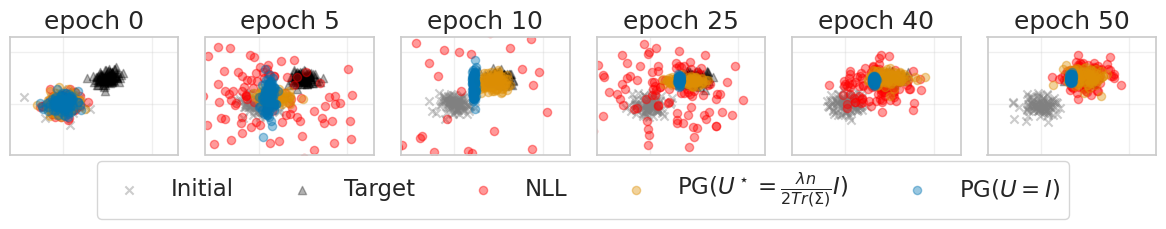

In [201]:
if len(all_dist_pg_list) == 1:
    plot_distribution_comparison(
        dist_nll=dist_nll,
        dist_pg=all_dist_pg_list[0],
        # indices=[0, 49, 99, 149, 199, 249],
        indices=[0, 5, 10, 25, 40, 50],
        n_samples=100,
        xlim=(-6, 13),
        ylim=(-10, 13),
        save_path="../figures/distribution_comparison.pdf",
        alpha=0.4,
    )

In [197]:
def plot_distribution_comparison_multi_entropy(
    dist_nll,
    dist_pg_list,
    entropy_weights,
    indices,
    n_samples=100,
    xlim=None,
    ylim=None,
    save_path=None,
    alpha=0.4,
    scatter_size=35,
):
    """
    Plot scatter plots comparing distributions at specified indices with multiple entropy weights.

    Args:
        dist_nll: List of torch normal distributions from NLL training
        dist_pg_list: List of dicts, each containing PG distribution lists for different entropy weights
        entropy_weights: List of entropy weight values corresponding to dist_pg_list
        indices: List of indices to plot
        n_samples: Number of samples to draw from each distribution
    """
    n_entropy = len(entropy_weights)
    n_plots = len(indices)
    fig, axes = plt.subplots(n_entropy, n_plots, figsize=(2 * n_plots, 2 * n_entropy))

    # Handle single row case
    if n_entropy == 1:
        axes = [axes]
    # Handle single column case
    if n_plots == 1:
        axes = [[ax] for ax in axes]

    # Define colors for each method
    default_palette = sns.color_palette()

    # Keep track of labels for single legend
    handles, labels = [], []

    for row, (entropy_weight, dist_pg) in enumerate(zip(entropy_weights, dist_pg_list)):
        colors = {
            "Initial": "gray",
            "Ground Truth": "black",
            "NLL": "red",
            list(dist_pg.keys())[0]: default_palette[1],
            list(dist_pg.keys())[1]: default_palette[0],
        }

        for col, idx in enumerate(indices):
            ax = axes[row][col]

            # Plot initial distribution
            samples_initial = initial_dist.sample((n_samples,))
            scatter = ax.scatter(
                samples_initial[:, 0],
                samples_initial[:, 1],
                alpha=alpha,
                s=scatter_size,
                color=colors["Initial"],
                label="Initial",
                marker="x",
            )
            if row == 0 and col == 0:
                handles.append(scatter)
                labels.append("Initial")

            # Plot ground truth distribution
            samples_gt = gt_dist.sample((n_samples,))
            scatter = ax.scatter(
                samples_gt[:, 0],
                samples_gt[:, 1],
                alpha=alpha,
                s=scatter_size,
                color=colors["Ground Truth"],
                label="Ground Truth",
                marker="^",
            )
            if row == 0 and col == 0:
                handles.append(scatter)
                labels.append("Target")

            # Plot NLL distribution if available
            if idx < len(dist_nll) and dist_nll[idx] is not None:
                samples_nll = dist_nll[idx].sample((n_samples,))
                scatter = ax.scatter(
                    samples_nll[:, 0],
                    samples_nll[:, 1],
                    alpha=alpha,
                    s=scatter_size,
                    color=colors["NLL"],
                    label="NLL",
                )
                if row == 0 and col == 0:
                    handles.append(scatter)
                    labels.append("NLL")

            # Plot PG distributions
            for method_name, dist_list in dist_pg.items():
                if idx < len(dist_list) and dist_list[idx] is not None:
                    samples_pg = dist_list[idx].sample((n_samples,))
                    scatter = ax.scatter(
                        samples_pg[:, 0],
                        samples_pg[:, 1],
                        alpha=alpha,
                        s=scatter_size,
                        color=colors[method_name],
                        label=method_name,
                    )
                    if row == 0 and col == 0:
                        handles.append(scatter)
                        labels.append(method_name)

            # Only add title to top row
            if row == 0:
                ax.set_title(f"epoch {idx}")

            ax.set_xlabel(None)
            if col == 0:
                ax.set_ylabel(r"$\lambda=$" + f"{entropy_weight}")
            else:
                ax.set_ylabel(None)
            ax.grid(True, alpha=0.3)
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            if xlim is not None:
                ax.set_xlim(xlim)
            if ylim is not None:
                ax.set_ylim(ylim)

    # Add single legend centered below all subplots
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.52, -0.05),
        ncol=len(labels),
    )

    plt.tight_layout()
    plt.subplots_adjust(left=0.1)  # Make room for entropy weight labels

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

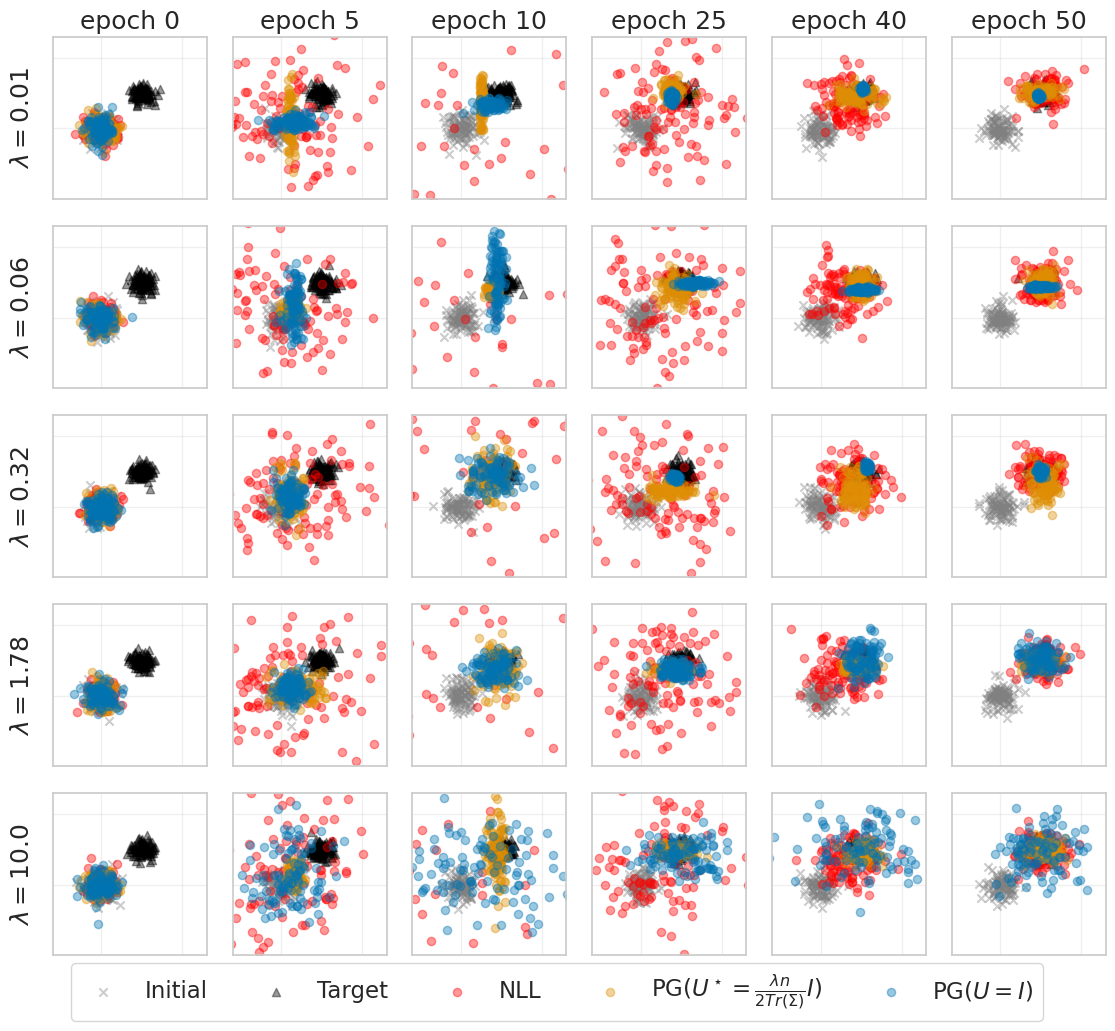

In [198]:
# Assuming you have multiple dist_pg dictionaries for different entropy weights
plot_distribution_comparison_multi_entropy(
    dist_nll=dist_nll,
    dist_pg_list=all_dist_pg_list,  # List of dist_pg dicts
    entropy_weights=entropy_weight_list,  # Corresponding entropy weights
    indices=[0, 5, 10, 25, 40, 50],
    n_samples=100,
    xlim=(-6, 13),
    ylim=(-10, 13),
    save_path="../figures/distribution_comparison_multi_entropy.pdf",
)